In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

df = pd.read_csv('water_quality.csv')
df.head()

,Station Code,Location,State,Temp,D.O. (mg/l),B.O.D. (mg/l),PH,Conductivity (µmhos/cm),TDS,Nitrate + Nitrite (mg/l),Fecal Coliform (MPN/100ml),Total Coliform (MPN/100ml),Year
0,1393.0,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,NaN,7.5,203.0,121.8,0.1,11,27,2014
1,1399.0,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,2,7.2,189.0,151.2,0.2,4953,8391,2014
2,1475.0,ZUARI AT PANCHAWADI,GOA,29.5,6.3,1.7,6.9,179.0,107.4,0.1,3243,5330,2014
3,3181.0,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,3.8,6.9,64.0,51.2,0.5,5382,8443,2014
4,3182.0,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,1.9,7.3,83.0,66.4,0.4,3428,5500,2014


In [2]:
df.describe()

,Station Code,D.O. (mg/l),PH,Conductivity (µmhos/cm),TDS,Year
count,1872.000000,1960.000000,1983.000000,1966.000000,1988.000000,1988.000000
mean,1954.897970,6.392637,7.195314,1892.268784,1329.699980,2010.038732
std,743.292758,1.332938,0.699855,5831.972586,4193.285404,3.054118
min,17.000000,0.000000,0.000000,11.000000,0.000000,2003.000000
25%,1448.000000,5.900000,6.900000,86.250000,58.400000,2008.000000
50%,1861.000000,6.700000,7.200000,196.000000,132.150000,2011.000000
75%,2424.000000,7.200000,7.600000,616.500000,412.255000,2013.000000
max,3473.000000,11.400000,9.010000,67115.000000,52560.000000,2014.000000


In [3]:
# Missing values before treatment
df.isnull().sum()

Station Code                  116
Location                        0
State                         749
Temp                           85
D.O. (mg/l)                    28
B.O.D. (mg/l)                  37
PH                              5
Conductivity (µmhos/cm)        22
TDS                             0
Nitrate + Nitrite (mg/l)      217
Fecal Coliform (MPN/100ml)    300
Total Coliform (MPN/100ml)    118
Year                            0
dtype: int64

In [4]:
# Converting features (expected) to dtype float and eliminating useless strings
def floatify_feature(col):
    for i, v in df[col].iteritems():
        try:
            float(v)
        except:
            df.at[i, col] = None
    df[col] = df[col].astype('float')

# Handling Missing values with mean imputation specific to the Station Code 
# i.e., for each missing value in a feature, check the station code and impute with mean value for the feature for the Station.
def handle_missing_values(col, treatment = 'Station Code'):
    floatify_feature(col)
    for i, row in df.loc[df[col].isnull()].iterrows():
        df.at[i, col] = df.loc[df[treatment] == row[treatment]].describe()[col]['mean']

# Handle Station Code missing value wrt Location
handle_missing_values('Station Code', 'Location')

# Perform Imputation only if no missing Station code.
if(df['Station Code'].isnull().sum() == 0):
    handle_missing_values('Temp')
    handle_missing_values('D.O. (mg/l)')
    handle_missing_values('B.O.D. (mg/l)')
    handle_missing_values('PH')
    handle_missing_values('Conductivity (µmhos/cm)')
    handle_missing_values('Nitrate + Nitrite (mg/l)')
    handle_missing_values('Fecal Coliform (MPN/100ml)')
    handle_missing_values('Total Coliform (MPN/100ml)')


In [5]:
# Missing values after treatment
df.isnull().sum()

Station Code                    0
Location                        0
State                         749
Temp                            3
D.O. (mg/l)                     2
B.O.D. (mg/l)                   3
PH                              0
Conductivity (µmhos/cm)         2
TDS                             0
Nitrate + Nitrite (mg/l)      131
Fecal Coliform (MPN/100ml)    193
Total Coliform (MPN/100ml)     51
Year                            0
dtype: int64

In [6]:
# Imputing remaining missing values with global average
numerical_columns = ['Temp', 'PH', 'D.O. (mg/l)', 'B.O.D. (mg/l)', 'Conductivity (µmhos/cm)', 'Nitrate + Nitrite (mg/l)', 'Fecal Coliform (MPN/100ml)', 'Total Coliform (MPN/100ml)']
for col in numerical_columns:
    df[col].fillna(df[col].mean(), inplace=True)

<AxesSubplot:>

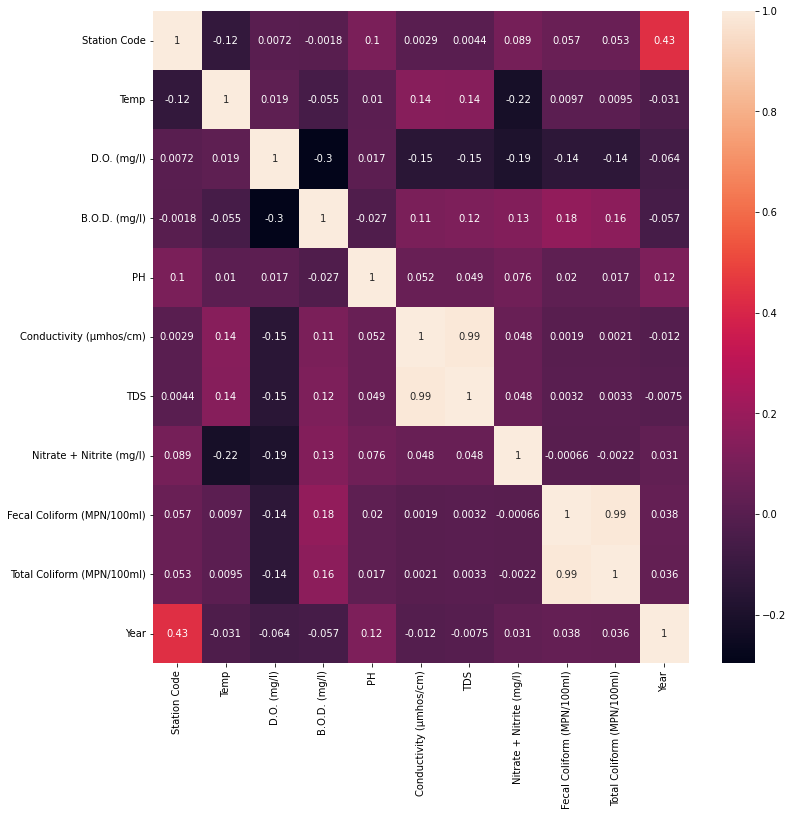

In [7]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), annot=True)

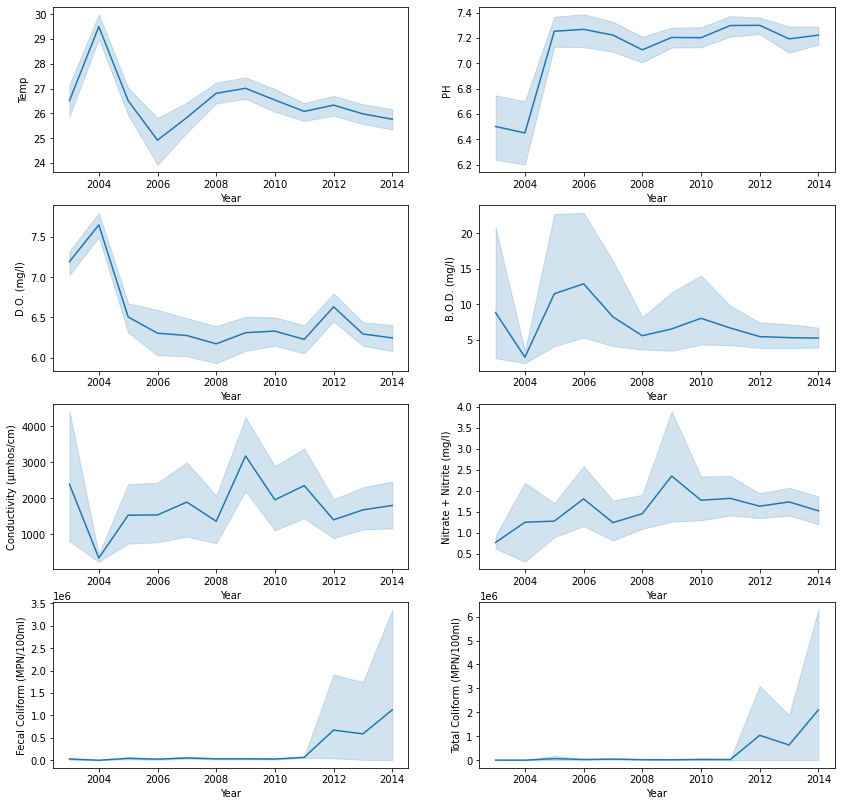

In [8]:
fig, ax = plt.subplots(int(len(numerical_columns)/2), 2, figsize=(14,14))
for i in range(len(numerical_columns)):
    sns.lineplot(ax=ax[int(i/2),i%2], data=df, x='Year', y=numerical_columns[i])

<AxesSubplot:ylabel='count'>

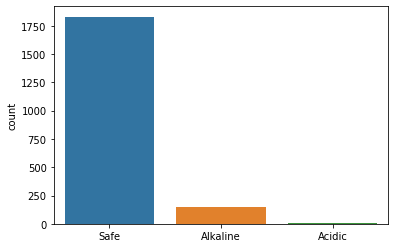

In [9]:
# df.PH = [x for v in df.PH if v]
PH_categorical = []
for v in df.PH:
    if v<6.5: PH_categorical.append('Alkaline')
    elif v>8.5: PH_categorical.append('Acidic')
    else: PH_categorical.append('Safe')
sns.countplot(x=PH_categorical)

<AxesSubplot:ylabel='count'>

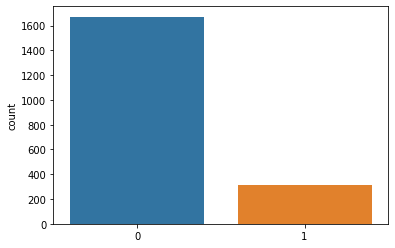

In [10]:
# Drinkable (Disclaimer: This doesn't guarantee if the water sample considered is safe to drink)
drinkable = []
for i, row in df.iterrows():
    # Hard Test - No parameter should be falling out of acceptable range
    if(row['PH'] > 6.5 and row['PH'] < 8.5 
        and row['D.O. (mg/l)'] > 6.5 and row['B.O.D. (mg/l)'] < 5.0 
        and row['TDS'] < 1000 and row['Nitrate + Nitrite (mg/l)'] < 1.0 
        and row['Total Coliform (MPN/100ml)'] < 500):
        drinkable.append(1)
    else: drinkable.append(0)
sns.countplot(x=drinkable)

In [11]:
# Hypothesis Test 1
t_score, p_val = stats.ttest_ind(df['Conductivity (µmhos/cm)'][:25], df['TDS'][:25])
print(t_score, p_val)

dof = 25 + 25 - 2  # degree of freedom
t_dist = stats.t(dof)

print(2*t_dist.cdf(t_score))
if p_val <  0.05: print("Reject Null Hypothesis")  # alpha set to 0.05
else: print("Accept Null Hypothesis")

1.8553232316962136 0.06969658371403789
1.9303034162859622
Accept Null Hypothesis


In [13]:
# Hypothesis Test 2
sample_ph_set = np.random.choice(list(df['PH']), 20)

t_score, p_val = stats.ttest_1samp(sample_ph_set, df['PH'].mean())
print(t_score, p_val)

if p_val <  0.05: print("Reject Null Hypothesis")
else: print("Accept Null Hypothesis")

print('Population Mean: ', np.mean(df['PH']))
print('Sample Mean: ', np.mean(sample_ph_set))

0.14323841936294257 0.8876100927089496
Accept Null Hypothesis
Population Mean:  7.197048169972214
Sample Mean:  7.2345


In [16]:
# Hypothesis Test 3
_, p_val = stats.ttest_ind(df['D.O. (mg/l)'], df['B.O.D. (mg/l)'])
print(p_val)
if p_val <  0.05: print("Reject Null Hypothesis")  # alpha set to 0.05
else: print("Accept Null Hypothesis")

-0.2965844431636377 1.1781406963730168e-41
Reject Null Hypothesis


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Location','State','TDS','PH', 'Year', 'Station Code'], axis=1), pd.Series(PH_categorical),test_size=0.3)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[5.87500000e-01, 5.87719298e-01, 2.15255030e-03, ...,
        9.19963201e-03, 6.71506366e-07, 8.21771670e-07],
       [7.50000000e-01, 5.96491228e-01, 2.33972859e-03, ...,
        4.59981601e-03, 4.77026380e-07, 9.48950618e-07],
       [9.04166667e-01, 2.89473684e-01, 1.96537202e-03, ...,
        8.92364305e-03, 1.83471685e-08, 2.34791906e-08],
       ...,
       [6.66666667e-01, 6.49122807e-01, 3.08844174e-03, ...,
        1.83992640e-03, 1.08248294e-05, 1.16906803e-05],
       [5.00000000e-01, 1.66666667e-01, 2.81703322e-02, ...,
        1.51082338e-02, 1.24241357e-03, 2.10334415e-06],
       [7.91666667e-01, 5.17543860e-01, 2.52690688e-03, ...,
        1.28794848e-03, 3.52999521e-06, 5.46673820e-06]])

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.931323283082077
